In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("ggplot")

import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from glob import glob
import seaborn as sns
import pprint as pp

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import np_utils
from keras.models import load_model
import itertools

import cv2
from PIL import Image

In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jithushaji","key":"14a5325c03bb921bed1ad1181ac323b4"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

100% 5.19G/5.20G [01:47<00:00, 71.6MB/s]
100% 5.20G/5.20G [01:47<00:00, 51.8MB/s]


In [ ]:
!unzip /content/skin-cancer-mnist-ham10000.zip -d /content/skin

In [ ]:
base_skin_dir = os.path.join('..', 'content/skin')

# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

# This dictionary is useful for displaying more human-friendly labels later on

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [ ]:
data = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

# Creating New Columns for better readability

data['path'] = data['image_id'].map(imageid_path_dict.get)
data['cell_type'] = data['dx'].map(lesion_type_dict.get) 
data['cell_type_idx'] = pd.Categorical(data['cell_type']).codes

data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../content/skin/HAM10000_images_part_1/ISIC_00...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../content/skin/HAM10000_images_part_1/ISIC_00...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../content/skin/HAM10000_images_part_1/ISIC_00...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../content/skin/HAM10000_images_part_1/ISIC_00...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../content/skin/HAM10000_images_part_2/ISIC_00...,Benign keratosis-like lesions,2


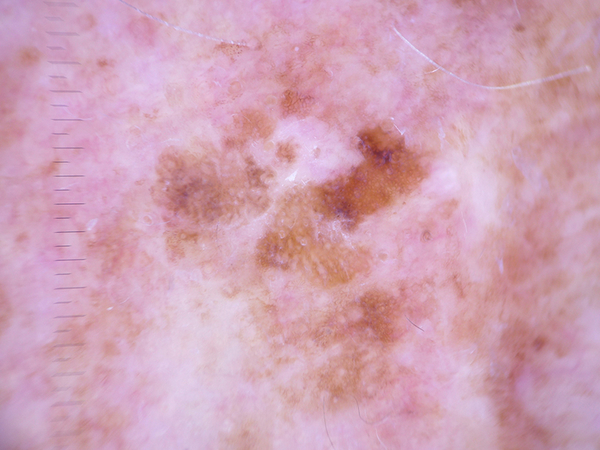

In [ ]:
Image.open('../content/skin/HAM10000_images_part_1/ISIC_0027419.jpg')

In [ ]:
files.download('/content/skin/HAM10000_images_part_2/ISIC_0032468.jpg')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

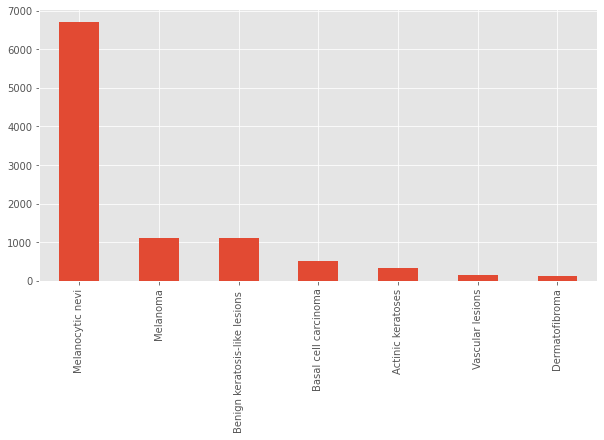

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
data['cell_type'].value_counts().plot(kind='bar', ax=ax1)

In [ ]:
data['cell_type'].value_counts() < 1000

Melanocytic nevi                  False
Melanoma                          False
Benign keratosis-like lesions     False
Basal cell carcinoma               True
Actinic keratoses                  True
Vascular lesions                   True
Dermatofibroma                     True
Name: cell_type, dtype: bool

In [ ]:
print(data['cell_type'].value_counts())

Melanocytic nevi                  6705
Melanoma                          1113
Benign keratosis-like lesions     1099
Basal cell carcinoma               514
Actinic keratoses                  327
Vascular lesions                   142
Dermatofibroma                     115
Name: cell_type, dtype: int64


In [ ]:
def balanced_dataset(df):
    df_balanced = pd.DataFrame()
    #df = pd.DataFrame()
    
    for cat in df['cell_type_idx'].unique():
        temp = resample(df[df['cell_type_idx'] == cat], 
                        replace=True,     # sample with replacement
                        n_samples=7000,   # to match majority class
                        random_state=123) # reproducible results

        # Combine majority class with upsampled minority class
        df_balanced = pd.concat([df_balanced, temp])
 
    df_balanced['cell_type'].value_counts()

    return df_balanced


In [ ]:
def load_img_data(size, df, balanced=False):
    """
        ..
        first we should normalize the image from 0-255 to 0-1
    """
    
    img_h, img_w = size, size
    imgs = []
    
    if balanced:
        df = balanced_dataset(df)
    
    image_paths = list(df['path'])
 
    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        img = img.astype(np.float32) / 255.
        #img = np.asarray(Image.open(image_paths[i]).resize((size,size)))
        imgs.append(img)
 
    imgs = np.stack(imgs, axis=0)
    print(imgs.shape)
 
    #imgs = imgs.astype(np.float32) / 255.
    
    return imgs, df['cell_type_idx'].values

In [ ]:
imgs, target   = load_img_data(128, data, balanced=False)

100%|██████████| 10015/10015 [01:34<00:00, 106.38it/s]


(10015, 128, 128, 3)


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(imgs, target, test_size=0.20)
x_train, x_val, y_train, y_val = train_test_split(imgs, target, test_size=0.05)

train_val_test = (x_train, y_train, x_val, y_val, x_test, y_test)

[x_train.shape, x_val.shape, x_test.shape]

[(9514, 128, 128, 3), (501, 128, 128, 3), (2003, 128, 128, 3)]

In [ ]:
alldata=(x_train, x_val, x_test)
alllabel=(y_train, y_val, y_test)

In [ ]:
class Tuner(object):

    def __init__(self, data, architecture, hidden_layers, classes, epochs, batch_size):
        self.input_shape = data[0][0].shape

        self.base_arch = architecture
        self.nn = self.download_network()
        self.nn.trainable = False

        self.hidden_layers = hidden_layers
        
        self.classes = classes

        self.trainX = data[0]
        self.trainY = data[1]
        self.valX = data[2]
        self.valY = data[3]
        self.testX = data[4]
        self.testY = data[5]

        self.EPOCHS = epochs
        self.BATCH_SIZE = batch_size

        self.model = self.build()
        self.train_generator = self.data_augmentation()
        self.predictions = None
        self.score = None

        self.best_weights = None

    def download_network(self):
        '''
        Download the requested CNN with imagenet weights
        '''
        nn = None

        if self.base_arch == 'VGG16':
            nn = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=self.input_shape)
        elif self.base_arch == 'VGG19':
            nn = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=self.input_shape)
        elif self.base_arch == 'InceptionV3':
            nn = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=self.input_shape)
        elif self.base_arch == 'Xception':
            nn = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=self.input_shape)
        elif self.base_arch == 'DenseNet121':
            nn = tf.keras.applications.DenseNet121(weights='imagenet', include_top=False, input_shape=self.input_shape)
        elif self.base_arch == 'DenseNet201':
            nn = tf.keras.applications.DenseNet201(weights='imagenet', include_top=False, input_shape=self.input_shape)
        elif self.base_arch == 'ResNet152V2':
            nn = tf.keras.applications.ResNet152V2(weights='imagenet', include_top=False, input_shape=self.input_shape)
        elif self.base_arch == 'MobileNet':
            nn = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=self.input_shape)
        elif self.base_arch == 'MobileNetV2':
            nn = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=self.input_shape)

        return nn

    def run(self):
        '''
        Main driver for Learner object
        '''
        self.fine_tune()
        #self.load_weights(self.best_weights)
        #self.predict()

    def build(self):
        '''
        Build model. Add Dense layer to topless base CNN.
        '''

        model = tf.keras.models.Sequential()
        model.add(self.nn)
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dropout(0.25))
        
        for layer in self.hidden_layers:
            model.add(tf.keras.layers.Dense(layer, activation='relu'))
            model.add(tf.keras.layers.BatchNormalization())
            model.add(tf.keras.layers.Dropout(0.46))  

        model.add(tf.keras.layers.Dense(self.classes, activation='softmax'))
        
        print (model.summary())

        return model

    def load_weights(self, name):
        '''
        Load the best checkpointed weights.
        '''
        print('\nLoading best accuracy weights.')
        self.model.load_weights(name)

    def data_augmentation(self):
        data_gen_args = dict(
                rotation_range=10,
                zoom_range=0.1,
                shear_range=0.1,
                width_shift_range=0.1, 
                height_shift_range=0.1,
                horizontal_flip=True,
                vertical_flip=True,
            )

        train_gen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)
        train_generator = train_gen.flow(self.trainX, self.trainY, batch_size=self.BATCH_SIZE)

        #print('\nData augmentation with the following parameters:')
        #pp.pprint(data_gen_args)

        return train_generator

    def get_class_weight(self):

        weight_for_0 = (1 / (self.trainY == 0).sum())*(len(self.trainY))/7.0 
        weight_for_1 = (1 / (self.trainY == 1).sum())*(len(self.trainY))/7.0
        weight_for_2 = (1 / (self.trainY == 2).sum())*(len(self.trainY))/7.0 
        weight_for_3 = (1 / (self.trainY == 3).sum())*(len(self.trainY))/7.0
        weight_for_4 = (1 / (self.trainY == 4).sum())*(len(self.trainY))/7.0 
        weight_for_5 = (1 / (self.trainY == 5).sum())*(len(self.trainY))/7.0
        weight_for_6 = (1 / (self.trainY == 6).sum())*(len(self.trainY))/7.0

        class_weight = {
            0: weight_for_0, 
            1: weight_for_1,
            2: weight_for_2, 
            3: weight_for_3,
            4: weight_for_4, 
            5: weight_for_5,
            6: weight_for_6, 
        }

        print('Class_weights:\n', class_weight, '\n')
        
        return class_weight

    def fine_tune(self):
        '''
        Fine-tune network in 2 phases
        '''

        numTrainingSamples = self.trainX.shape[0]
        numValidationSamples = self.valX.shape[0]

        print ("\nPhase A - Training Fully Connected Layers\n")
        self.model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.001), metrics=['accuracy'])

        # Define checkpoint to save best Phase 1 weights
        best_weights_ph1 = self.base_arch + "_ph1_weights.hdf5"
        checkpoint = tf.keras.callbacks.ModelCheckpoint(best_weights_ph1, monitor="val_loss", mode="min", save_best_only=True, verbose=1)
        
        history = self.model.fit(
            x_train, y_train,
            #self.train_generator,
            steps_per_epoch=numTrainingSamples // self.BATCH_SIZE,
            epochs=self.EPOCHS,
            validation_data=(self.valX, self.valY),
            validation_steps=numValidationSamples // self.BATCH_SIZE,
            #class_weight=self.get_class_weight(),
            callbacks=[checkpoint])
        
        # Store the best phase 1 accuracy
        best_acc_ph1 = max(history.history["val_accuracy"])
        print('\n\nMax validation accuracy:', best_acc_ph1)

        print('\nRestoring best weights and predicting validation set.')
        self.load_weights(best_weights_ph1)

        # Make predictions based on best phase 1 weights
        self.predict()

        self.plot_loss(history, self.EPOCHS, '\n Transfer Learning: ' + self.base_arch + ' Ph A')
        

        print ("\nPhase B  - Fine Tune all Layers \n")
        # Set full original CNN as trainable
        self.nn.trainable = True

        self.model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=1e-5), metrics=['accuracy'])

        # Define checkpoint to save best Phase 2 weights
        best_weights_ph2 = self.base_arch + "_ph2_weights.hdf5"
        checkpoint = tf.keras.callbacks.ModelCheckpoint(best_weights_ph2, monitor="val_loss", mode="min", save_best_only=True, verbose=1)

        # Fine-tune the full CNN + FC
        history = self.model.fit(
            x_train, y_train,
            #self.train_generator,
            steps_per_epoch=numTrainingSamples // self.BATCH_SIZE,
            epochs=self.EPOCHS,
            validation_data=(self.valX, self.valY),
            validation_steps=numValidationSamples // self.BATCH_SIZE,
            #class_weight=self.get_class_weight(),
            callbacks=[checkpoint])

        # Store the best phase 2 accuracy
        best_acc_ph2 = max(history.history["val_accuracy"])
        print('\n\nMax validation accuracy:', best_acc_ph2)

        # Only if Phase 2 fine-tuning resulted in a better accuracy than phase 1,
        # restore best phase 2 weights and update Tuner predictions.
        if best_acc_ph2 > best_acc_ph1:
            print('\nPhase 2 resulted in better accuracy than Phase 1.')
            print('Restoring best weights of Ph2 and predicting validation set.')
            self.load_weights(best_weights_ph2)
            self.predict()

        self.plot_loss(history, self.EPOCHS, '\n Transfer Learning: ' + self.base_arch + ' Ph B')
    
    def predict(self):
        '''
        Get predictions and score for validation set.
        '''
        print('\nPredicting test set classes.')
        self.score = self.model.evaluate(self.testX, self.testY, verbose=0)
        print('Test set score:', self.score)
        self.predictions = self.model.predict(self.testX, batch_size=self.BATCH_SIZE)
        print('Done')

    def plot_loss(self, history, epochs, name):
        print('\n\n')
        plt.figure(figsize=(12,8))
        plt.plot(np.arange(0, epochs), history.history["loss"], label="train_loss")
        plt.plot(np.arange(0, epochs), history.history["val_loss"], label="val_loss")
        plt.plot(np.arange(0, epochs), history.history["accuracy"], label="train_acc")
        plt.plot(np.arange(0, epochs), history.history["val_accuracy"], label="val_acc")
        plt.title("Training Loss and Accuracy - {}".format(name))
        plt.xlabel("Epoch #")
        plt.ylabel("Loss/Accuracy")
        plt.legend()
        plt.show()

74842112/74836368 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 4, 4, 1920)        18321984  
_________________________________________________________________
flatten (Flatten)            (None, 30720)             0         
_________________________________________________________________
dropout (Dropout)            (None, 30720)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               15729152  
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________

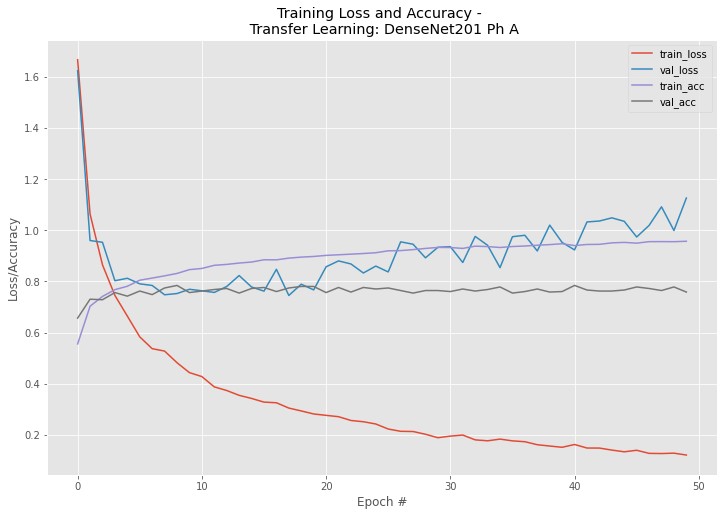


Phase B  - Fine Tune all Layers 

Epoch 1/50
74/74 [==============================] - ETA: 0s - loss: 1.4837 - accuracy: 0.6518WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0309s vs `on_test_batch_end` time: 0.1035s). Check your callbacks.

Epoch 00001: val_loss improved from inf to 0.96402, saving model to DenseNet201_ph2_weights.hdf5
74/74 [==============================] - 35s 479ms/step - loss: 1.4837 - accuracy: 0.6518 - val_loss: 0.9640 - val_accuracy: 0.7345
Epoch 2/50
74/74 [==============================] - ETA: 0s - loss: 0.9762 - accuracy: 0.7286
Epoch 00002: val_loss did not improve from 0.96402
74/74 [==============================] - 28s 382ms/step - loss: 0.9762 - accuracy: 0.7286 - val_loss: 1.1016 - val_accuracy: 0.7186
Epoch 3/50
74/74 [==============================] - ETA: 0s - loss: 0.7616 - accuracy: 0.7762
Epoch 00003: val_loss did not improve from 0.96402
74/74 [==============================] - 28s 38

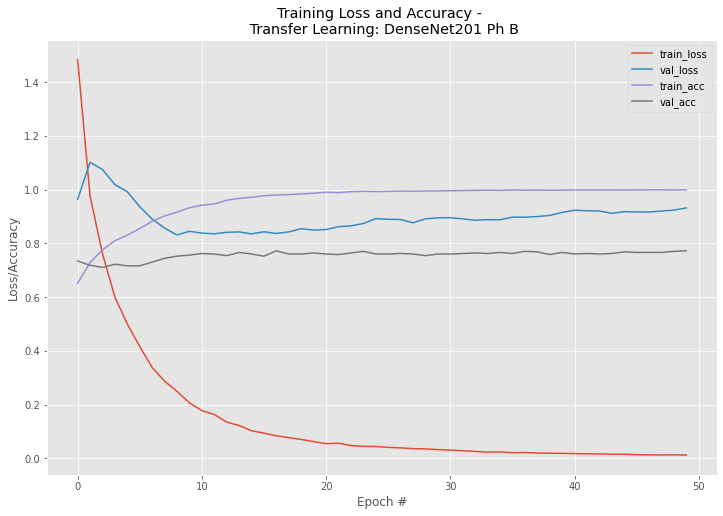

In [ ]:
NET = 'DenseNet201'
HIDDEN_LAYERS = [512, 128]
#HIDDEN_LAYERS = [256, 256, 64]
CLASSES = len(set(target))
BATCH_SIZE = 128
EPOCHS = 50

model = Tuner(train_val_test, NET, HIDDEN_LAYERS, CLASSES, EPOCHS, BATCH_SIZE)
model.run()

In [ ]:
model.predict()


Predicting test set classes.
Test set score: [0.04041701927781105, 0.9910134673118591]
Done


In [ ]:
# Function to plot confusion matrix    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')




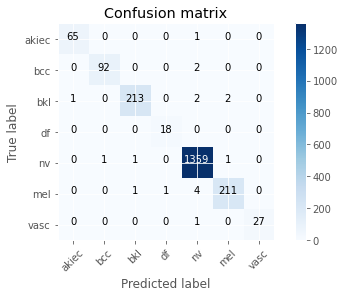

In [ ]:
# Predict the values from the validation dataset
Y_pred = model.predictions
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
#Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_test, Y_pred_classes)

 
classes=['akiec', 'bcc', 'bkl', 'df', 'nv', 'mel', 'vasc']
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes) 

In [ ]:
model.model.save("7cancermodel_Densenet201", save_format="h5")

In [ ]:
model_json = model.model.to_json()
with open("SkinCancer_DenseNET201.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
model.model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 4, 4, 1920)        18321984  
_________________________________________________________________
flatten (Flatten)            (None, 30720)             0         
_________________________________________________________________
dropout (Dropout)            (None, 30720)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               15729152  
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               6

In [ ]:
new_model = load_model('/content/7cancermodel_Densenet201')

In [ ]:
predy=new_model.predict(x_test, batch_size=BATCH_SIZE)

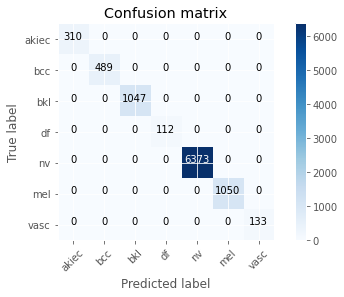

In [ ]:
# Predict the values from the validation dataset
Y_pred = new_model.predict(x_train, batch_size=BATCH_SIZE)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
#Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_train, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes) 

In [ ]:
label_map = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'mel', 'vasc']
print(label_map)

['akiec', 'bcc', 'bkl', 'df', 'nv', 'mel', 'vasc']


In [ ]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 4, 4, 1920)        18321984  
_________________________________________________________________
flatten (Flatten)            (None, 30720)             0         
_________________________________________________________________
dropout (Dropout)            (None, 30720)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               15729152  
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               6

In [ ]:
img_path="/content/skin/HAM10000_images_part_2/"
filen='ISIC_0032468.jpg'
imgas=[]
iamg = cv2.imread(img_path + filen)
iamg = cv2.resize(iamg, (128, 128))
iamg = iamg.astype(np.float32) / 255.
imgas.append(iamg)
        #img = np.asarray(Image.open(image_paths[i]).resize((size,size)))
  
imgas = np.stack(imgas, axis=0)
print(imgas.shape)
 


(1, 128, 128, 3)


In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

In [ ]:
img_path="../content/skin/HAM10000_images_part_1/"
filee='ISIC_0025661.jpg'
imge = image.load_img(img_path + filee, target_size=(128, 128))
img_array = image.img_to_array(imge)
img_array_expanded_dims = np.expand_dims(img_array, axis=0)
out=tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

In [ ]:
predic=new_model.predict(imgas)

In [ ]:
classes = predic.argmax(axis=-1)
print(classes)

[3]
